In [39]:
%pip install git+https://github.com/lucasb-eyer/pydensecrf.git

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /private/var/folders/q3/rnsm0fg975ld64pvb5fc5dmm0000gn/T/pip-req-build-cp9fvoh5
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /private/var/folders/q3/rnsm0fg975ld64pvb5fc5dmm0000gn/T/pip-req-build-cp9fvoh5
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [48]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from skimage import io
from skimage.transform import resize
import pydensecrf.densecrf as dcrf

EPS = 1e-6

# ------------------------------ utilities ------------------------------

def _to_uint8_rgb(img, target_hw):
    """Return uint8 RGB image of shape (H,W,3) matching target_hw."""
    H, W = target_hw
    arr = np.asarray(img)
    if arr.ndim == 2:
        arr = np.stack([arr]*3, axis=-1)
    elif arr.ndim == 3 and arr.shape[-1] == 4:
        arr = arr[..., :3]
    elif arr.ndim == 3 and arr.shape[-1] == 1:
        arr = np.repeat(arr, 3, axis=-1)

    if arr.shape[:2] != (H, W):
        arr = resize(arr, (H, W, 3), preserve_range=True, anti_aliasing=True)

    if arr.dtype != np.uint8:
        arr = np.clip(arr, 0, 255).astype(np.uint8)

    return np.ascontiguousarray(arr)


def _load_mask_binary(path, target_hw=None):
    """Load a PNG mask and return boolean array of shape (H,W)."""
    m = io.imread(path)
    if m.ndim == 3:
        m = m.mean(axis=-1)  # to grayscale
    # Heuristic threshold depending on dtype
    if np.issubdtype(m.dtype, np.integer):
        thr = 128
    else:
        thr = 0.5
    m = (m > thr)
    if target_hw is not None and m.shape != target_hw:
        m = resize(m.astype(np.float32), target_hw, preserve_range=True, anti_aliasing=False) > 0.5
    return m.astype(bool)


def _prepare_prob_map(pm, target_hw):
    """
    Return float32 foreground probability in (0,1) with shape (H,W).
    Accepts shapes: (H,W), (H,W,2), (2,H,W), (H*W,)
    """
    pm = np.asarray(pm)
    H, W = target_hw

    # Select/derive foreground channel
    if pm.ndim == 3:
        if pm.shape[-1] == 2:          # (H,W,2), foreground at [:,:,1]
            pm = pm[..., 1]
        elif pm.shape[0] == 2:         # (2,H,W), foreground at [1,:,:]
            pm = pm[1]
        else:
            pm = pm.mean(axis=-1)      # fallback: average channels
    elif pm.ndim == 1 and pm.size == H * W:
        pm = pm.reshape(H, W)
    elif pm.ndim != 2:
        raise ValueError(f"Unsupported prob_map shape {pm.shape}")

    # Resize if needed
    if pm.shape != (H, W):
        pm = resize(pm, (H, W), preserve_range=True, anti_aliasing=True)

    pm = pm.astype(np.float32)

    # Fix degenerate maps (all-0, all-1, or constant)
    unique_vals = np.unique(pm)
    if set(unique_vals).issubset({0.0, 1.0}) or np.allclose(pm.min(), pm.max()):
        pm = 0.001 + 0.998 * pm  # push away from {0,1}

    # Clip to open interval
    pm = np.clip(pm, EPS, 1.0 - EPS)
    return pm


# ------------------------------ CRF core ------------------------------

def run_crf(original_image_uint8_rgb, prob_map_fg):
    """
    DenseCRF2D refinement for 2 classes [bg, fg].
    original_image_uint8_rgb: (H,W,3) uint8
    prob_map_fg: (H,W) float32 in (0,1)
    """
    H, W = original_image_uint8_rgb.shape[:2]

    # Build prob tensor [bg, fg] and unary
    p_fg = prob_map_fg.astype(np.float32)
    p_bg = 1.0 - p_fg
    P = np.stack([p_bg, p_fg], axis=0)             # (2,H,W)
    P /= (P.sum(axis=0, keepdims=True) + EPS)

    unary = (-np.log(P + EPS)).reshape(2, -1).astype(np.float32)
    unary = np.ascontiguousarray(unary)

    # DenseCRF
    d = dcrf.DenseCRF2D(W, H, 2)
    d.setUnaryEnergy(unary)

    # Safe high-level pairwise terms; avoids channel-index traps
    d.addPairwiseGaussian(sxy=(3, 3), compat=3)
    d.addPairwiseBilateral(sxy=(80, 80), srgb=(13, 13, 13), rgbim=original_image_uint8_rgb, compat=10)

    Q = np.array(d.inference(10), dtype=np.float32)  # (2, H*W)
    refined = np.argmax(Q, axis=0).reshape(H, W).astype(np.uint8)
    return refined


# ------------------------------ driver ------------------------------

def crf_eval_folder(
    image_path_folder,
    mask_path_folder,
    prob_map_folder,
    cocojson_file=None,              # unused placeholder to match your signature
    limit=None,                      # set int to limit processed files
    save_refined_to=None,            # folder to save refined masks as PNGs
    show=True                        # show matplotlib triptychs
):
    """
    Expects for each image 'X.jpeg':
      - mask at mask_path_folder / 'X_predicted_mask.png'  (binary PNG)
      - prob map at prob_map_folder / 'X_prob_map.npy'     (foreground prob)
    """
    image_files = sorted([f for f in os.listdir(image_path_folder)
                          if f.lower().endswith(('.jpeg', '.jpg', '.png'))])

    if save_refined_to:
        os.makedirs(save_refined_to, exist_ok=True)

    f1_results = {}
    processed = 0

    for filename in image_files:
        if limit is not None and processed >= limit:
            break

        try:
            base = os.path.splitext(filename)[0]
            image_path = os.path.join(image_path_folder, filename)
            pred_mask_path = os.path.join(mask_path_folder, f"{base}_predicted_mask.png")
            prob_map_path = os.path.join(prob_map_folder, f"{base}_prob_map.npy")

            if not os.path.exists(pred_mask_path) or not os.path.exists(prob_map_path):
                print(f"skip {filename}: missing mask or prob map")
                continue

            # Load mask first to define target size
            mask = _load_mask_binary(pred_mask_path)
            H, W = mask.shape

            # Load and prep image
            img = io.imread(image_path)
            img_u8_rgb = _to_uint8_rgb(img, (H, W))

            # Load and prep prob map
            pm_raw = np.load(prob_map_path, allow_pickle=False)
            pm = _prepare_prob_map(pm_raw, (H, W))

            # Diagnostics
            print(f"{filename}: img{img_u8_rgb.shape} pm{pm.shape}[{pm.min():.4f},{pm.max():.4f}] mask{mask.shape}")

            # CRF refine
            refined = run_crf(img_u8_rgb, pm)

            # Optional save
            if save_refined_to:
                out_path = os.path.join(save_refined_to, f"{base}_crf.png")
                io.imsave(out_path, (refined * 255).astype(np.uint8), check_contrast=False)

            # Compute F1 vs provided mask (change to GT mask if you have it)
            y_true = mask.astype(np.uint8).ravel()
            y_pred = refined.astype(np.uint8).ravel()
            f1 = f1_score(y_true, y_pred, zero_division=0)
            f1_results[filename] = float(f1)

            # Show
            if show:
                plt.figure(figsize=(12, 4))
                plt.suptitle(f"CRF Refinement: {filename}", fontsize=12)
                plt.subplot(1, 3, 1); plt.imshow(img_u8_rgb); plt.title("Original"); plt.axis('off')
                plt.subplot(1, 3, 2); plt.imshow(mask, cmap='gray'); plt.title("Mask (input)"); plt.axis('off')
                plt.subplot(1, 3, 3); plt.imshow(refined, cmap='gray'); plt.title("Refined (CRF)"); plt.axis('off')
                plt.tight_layout(); plt.show()

            processed += 1

        except Exception as e:
            print(f"ERROR {filename}: {e}")

    return f1_results


# ------------------------------ example call ------------------------------
# crf_eval_folder(
#     image_path_folder="/Users/ammaster10/Documents/Github/Year4/CNVresearch/Validation/340_Folder/340_Test",
#     mask_path_folder="/Users/ammaster10/Documents/Github/Year4/CNVresearch/Validation/340_Folder/GVF_Ready",
#     prob_map_folder="/Users/ammaster10/Documents/Github/Year4/CNVresearch/Validation/340_Folder/predicted_prob_maps_npy",
#     cocojson_file="/Users/ammaster10/Documents/Github/Year4/CNVresearch/Validation/340_Folder/subset_340.json",
#     limit=None,
#     save_refined_to="/Users/ammaster10/Documents/Github/Year4/CNVresearch/Validation/340_Folder/CRF_Refined",
#     show=True
# )

CNV-1016042-108.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


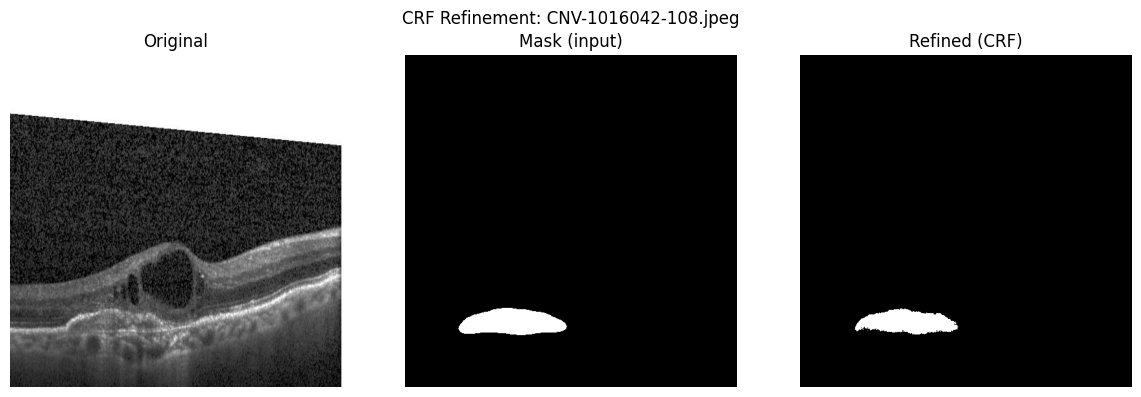

CNV-1016042-12.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


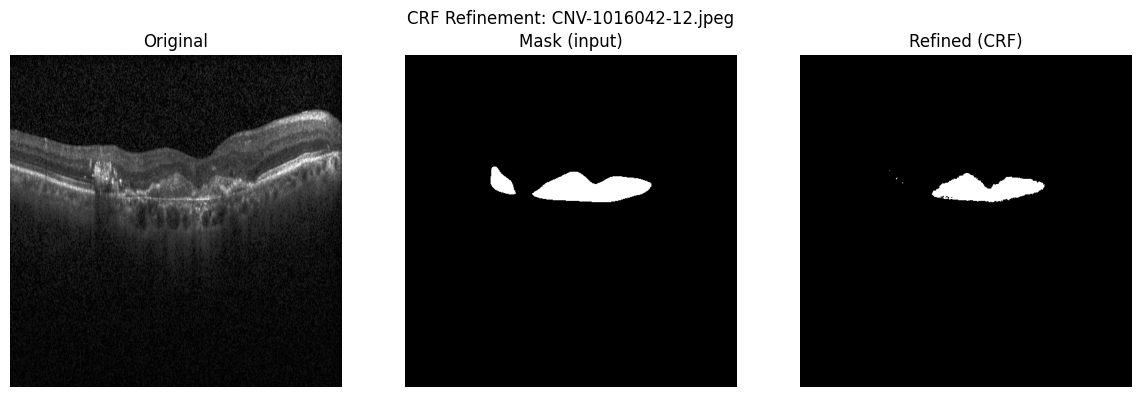

CNV-1016042-191.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


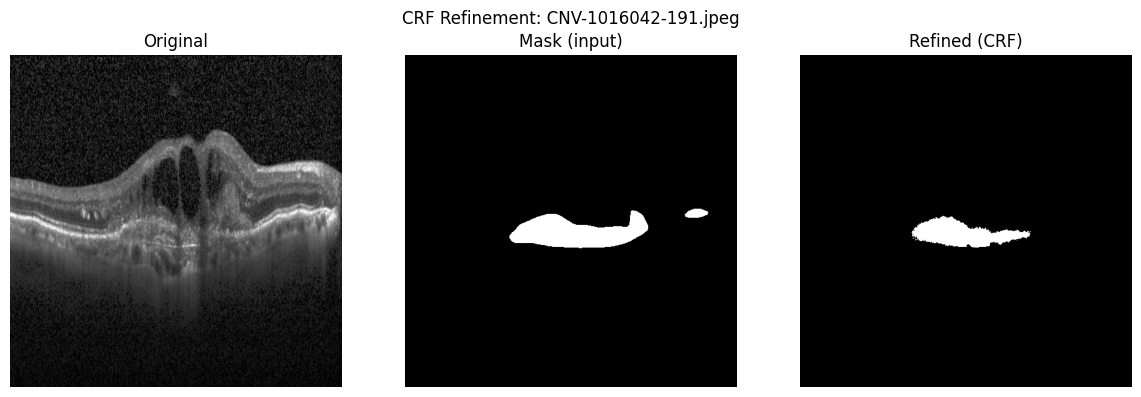

CNV-1016042-42.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


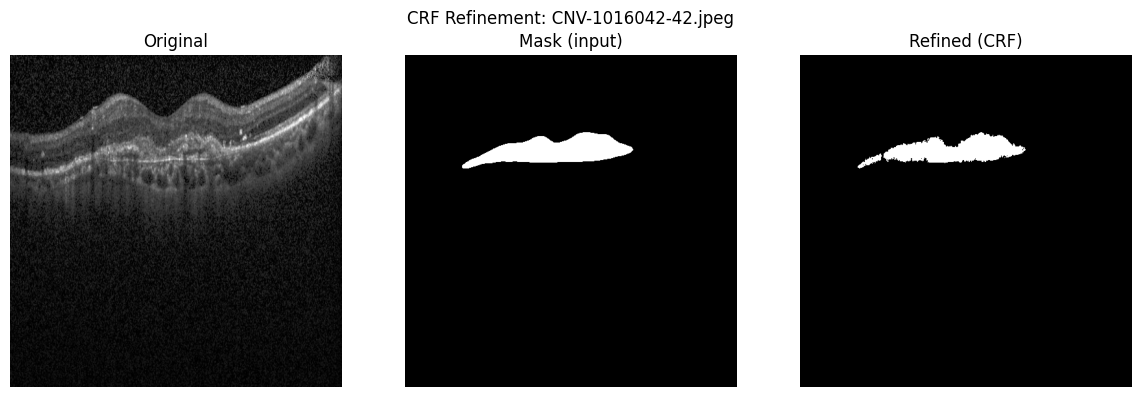

CNV-103044-58.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


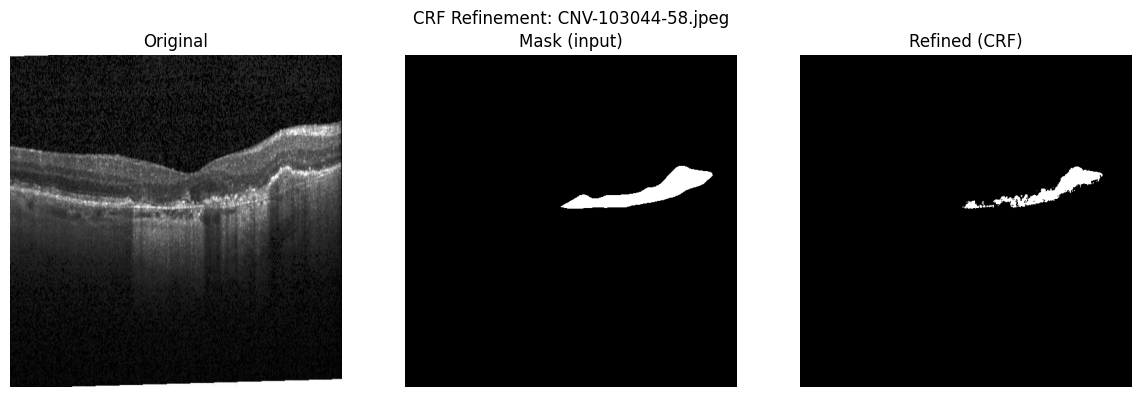

CNV-103044-62.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


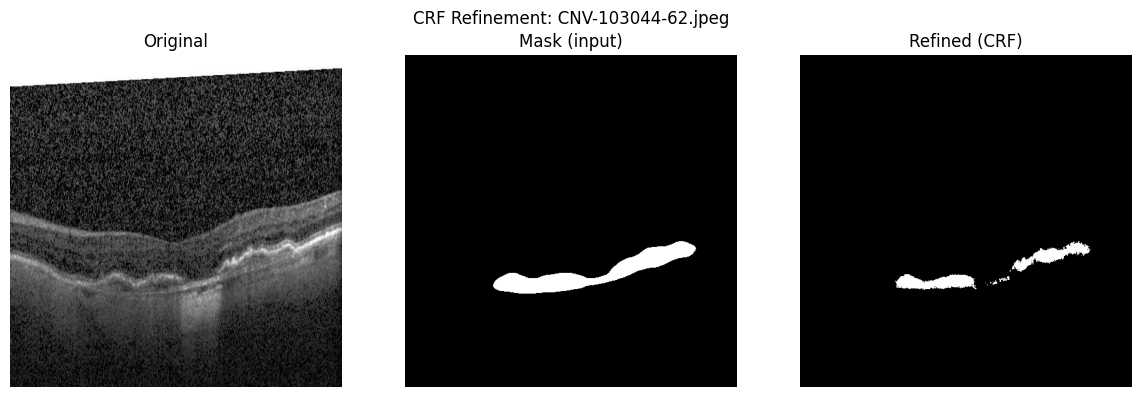

CNV-1083927-51.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,0.9999] mask(512, 512)


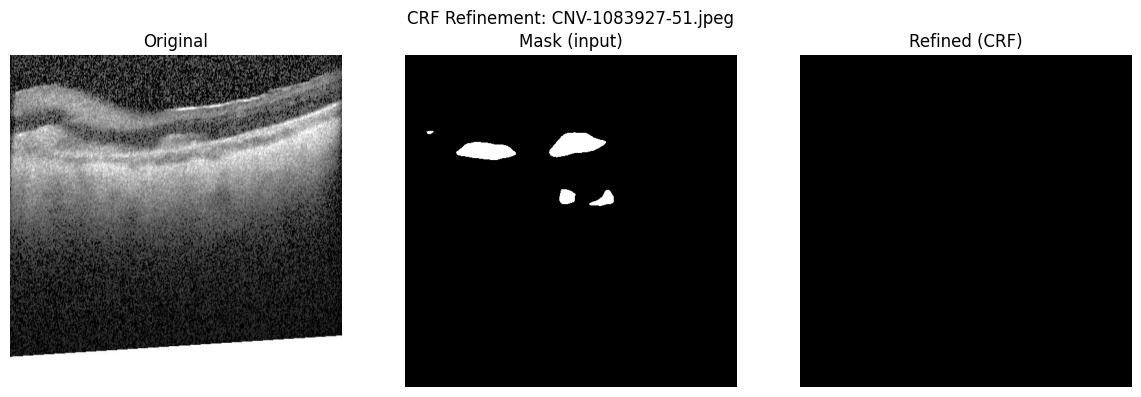

CNV-1083927-97.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


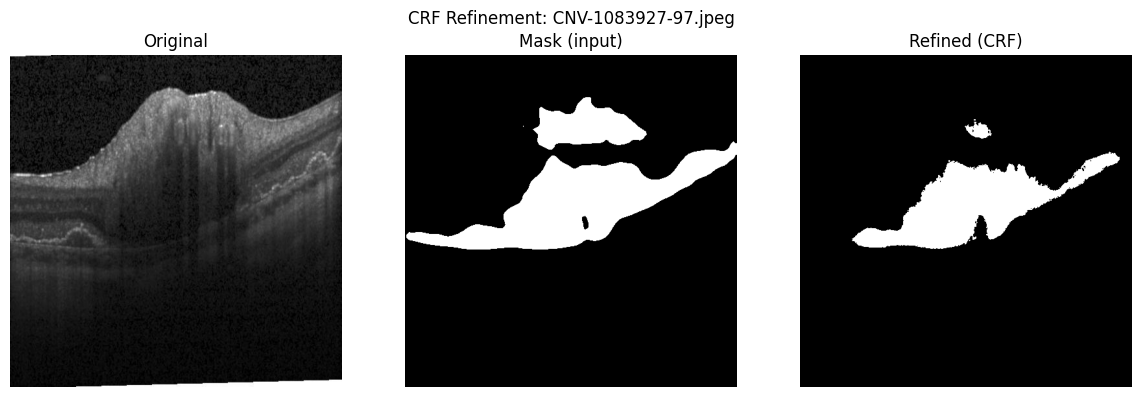

CNV-1112835-153.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,0.6005] mask(512, 512)


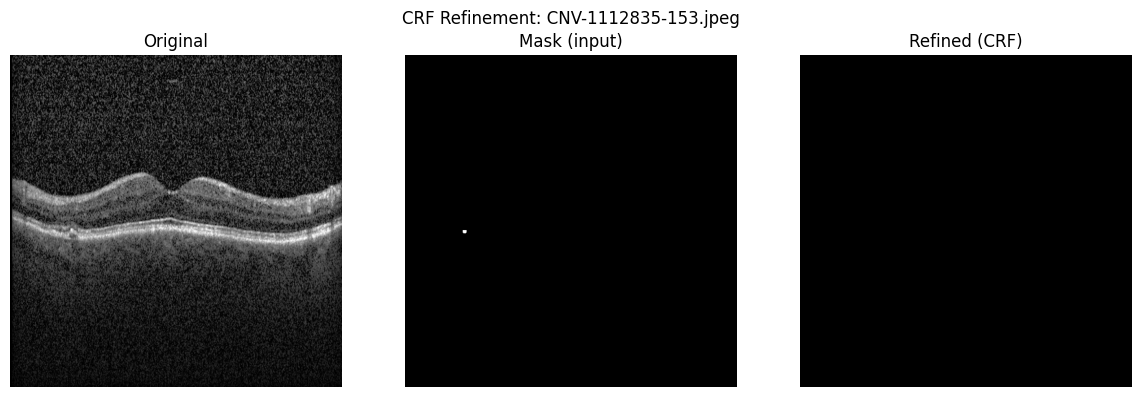

CNV-1112835-372.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


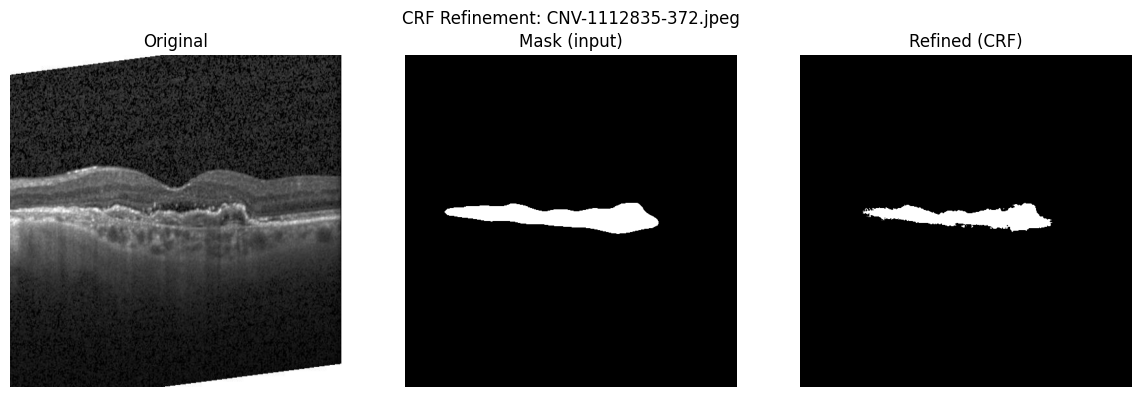

CNV-1169820-74.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


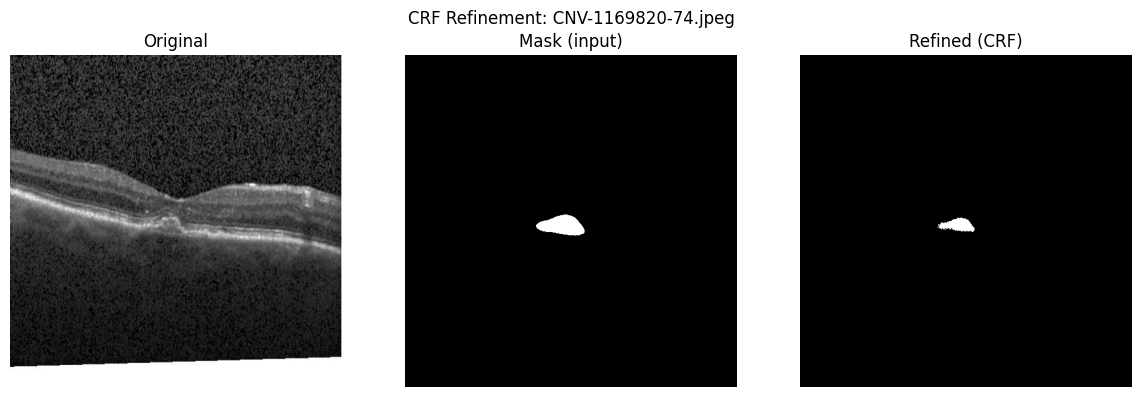

CNV-1173253-22.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


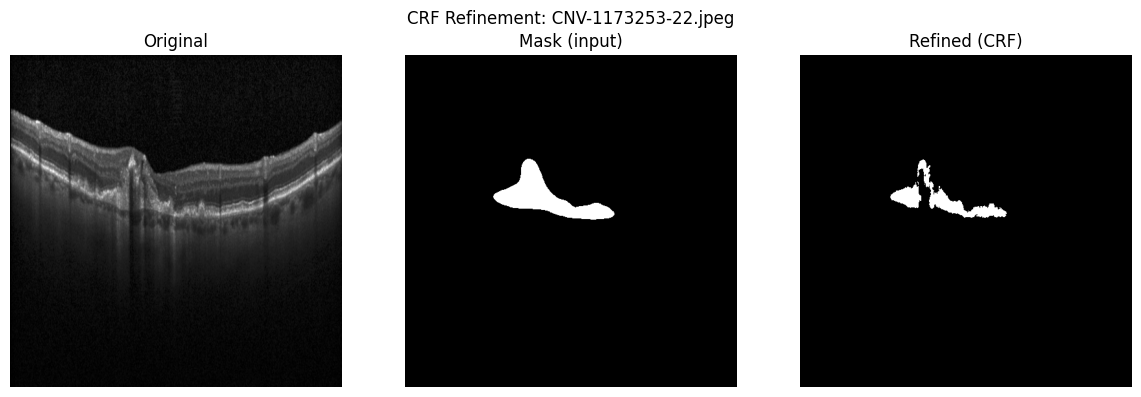

CNV-1188386-1.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


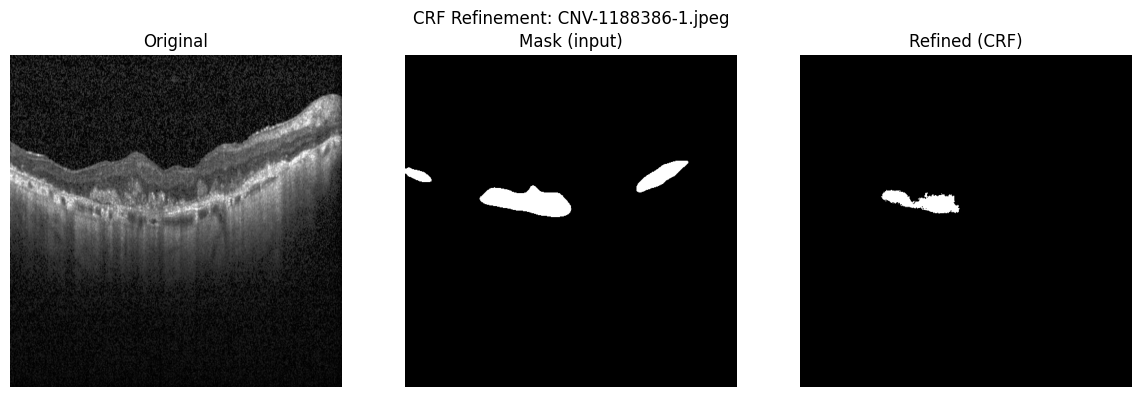

CNV-1188386-278.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


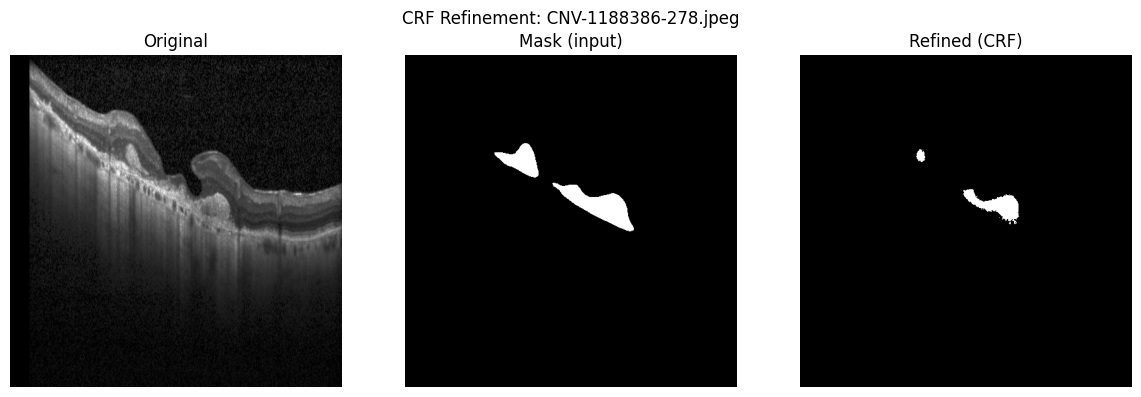

CNV-1188386-373.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


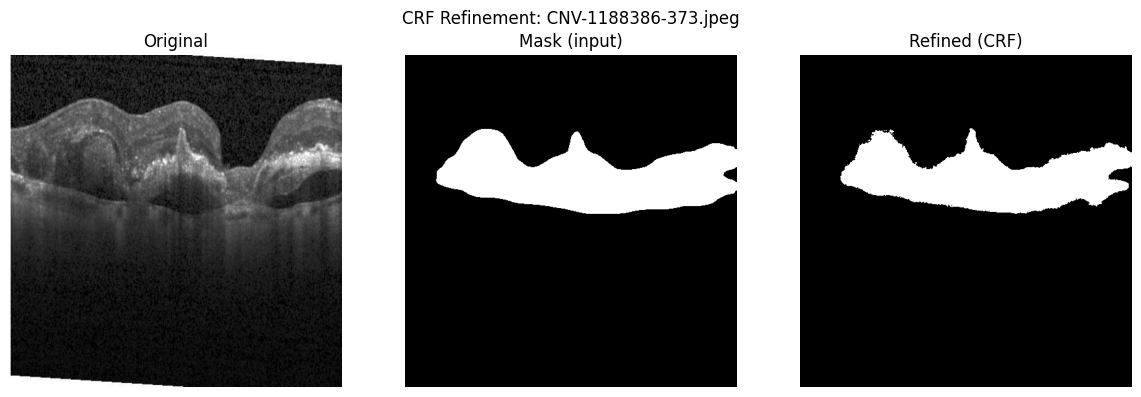

CNV-1188386-385.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


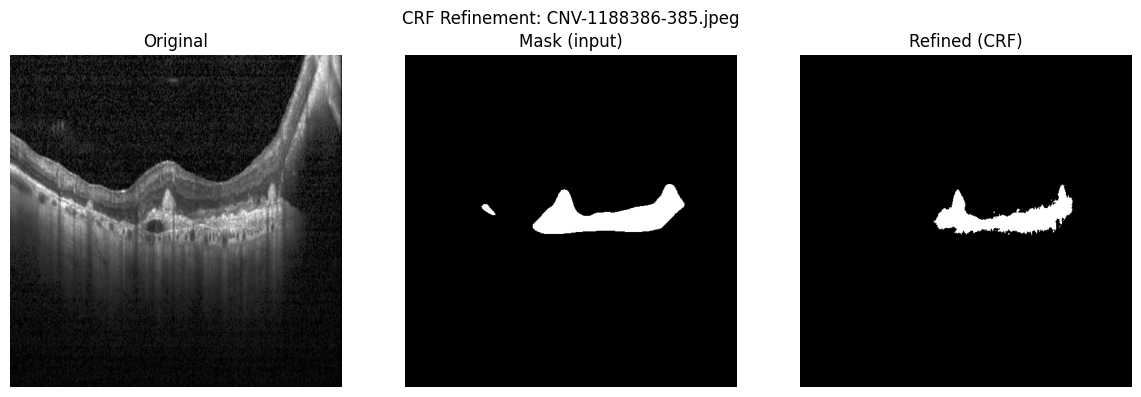

CNV-1188386-419.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


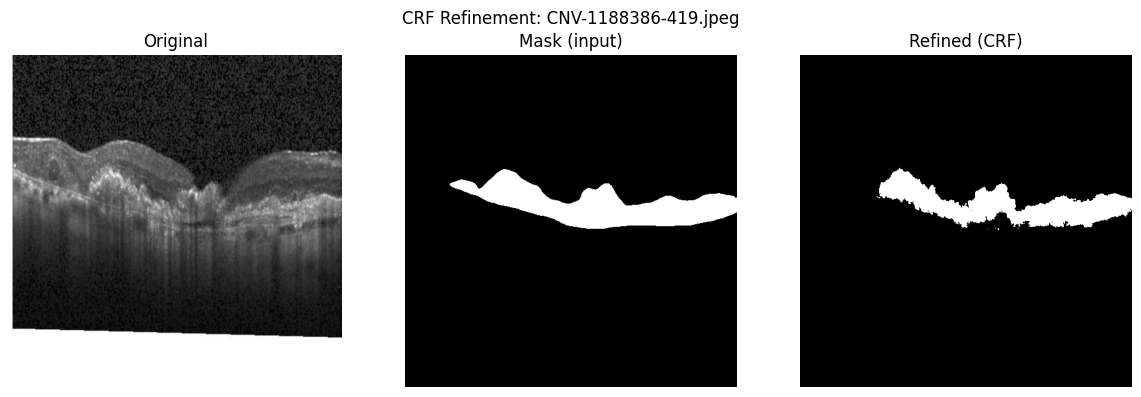

CNV-1188386-455.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


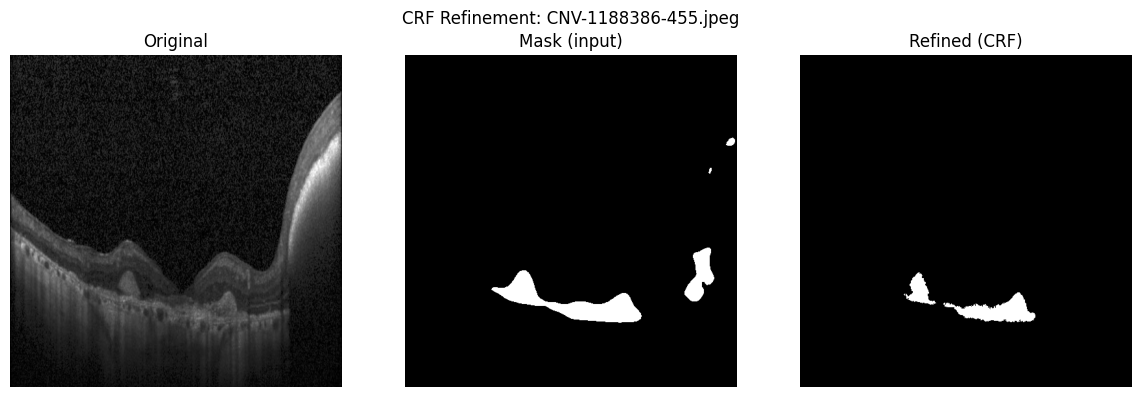

CNV-1188386-567.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


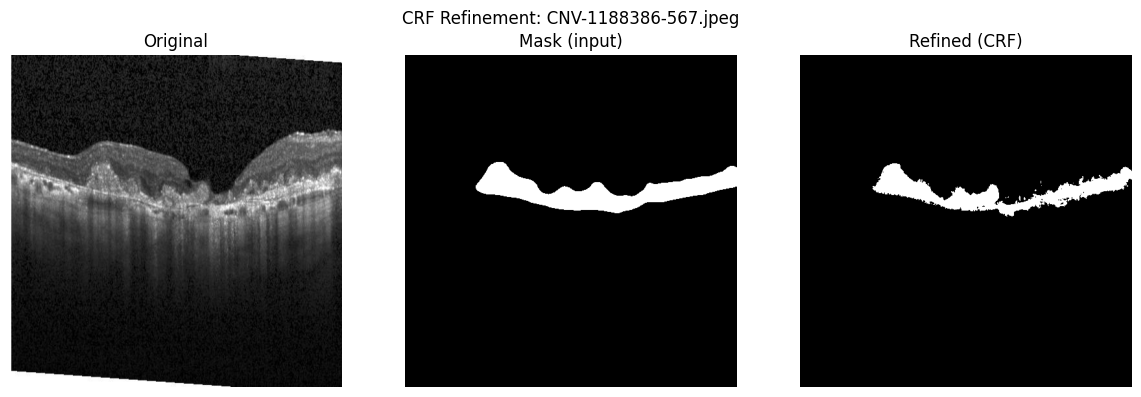

CNV-1188386-613.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


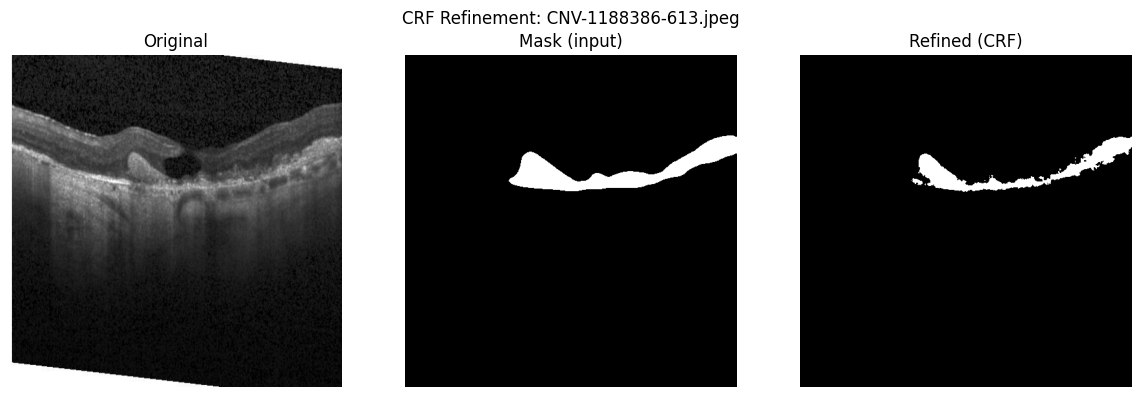

CNV-1188386-638.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


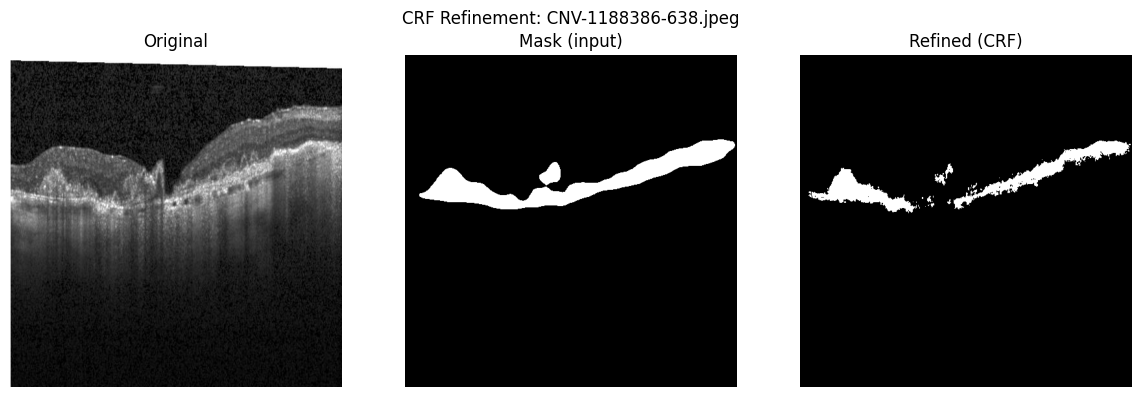

CNV-1188386-692.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


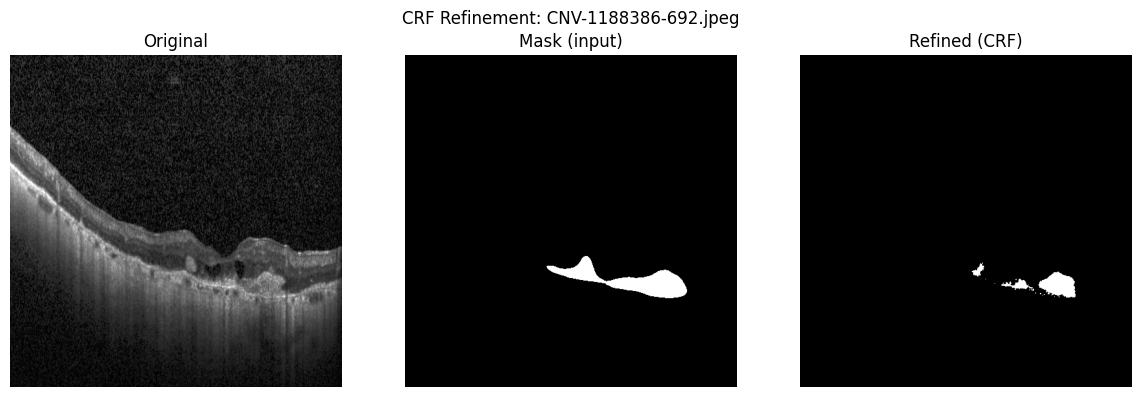

CNV-1260317-32.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


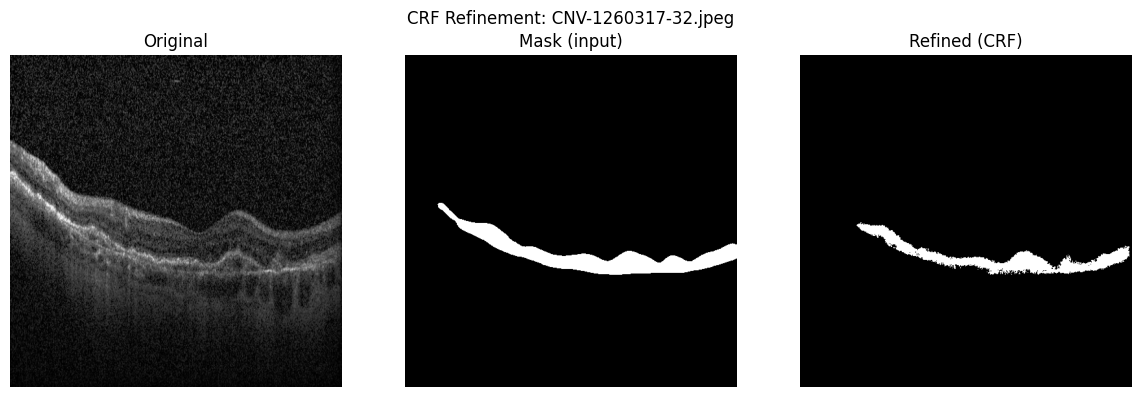

CNV-1279887-33.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


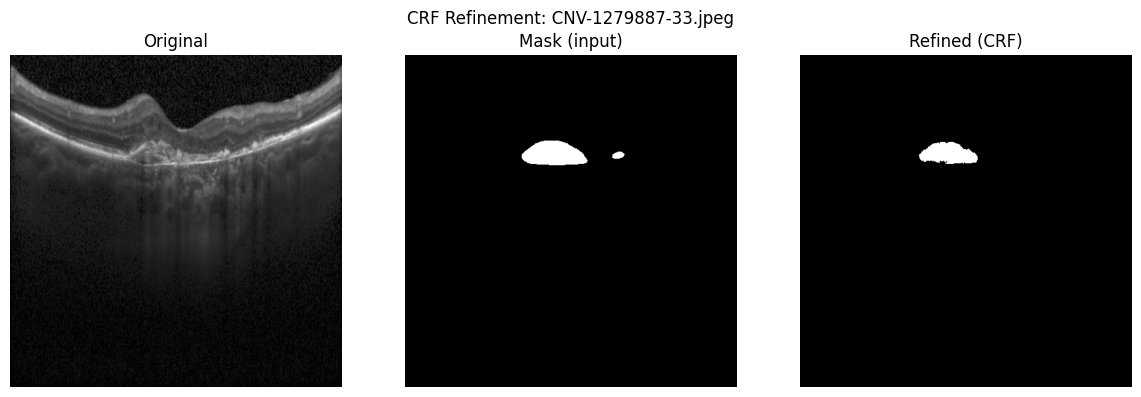

CNV-1279887-52.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


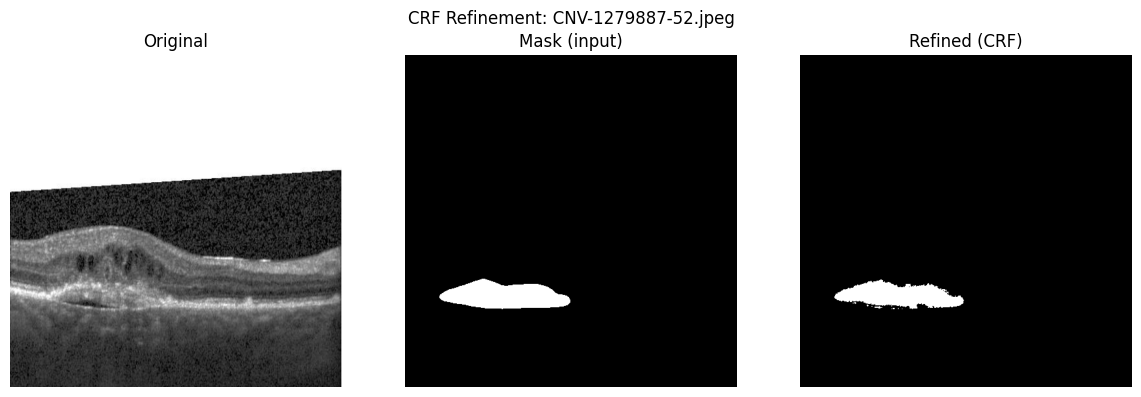

CNV-1290410-11.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


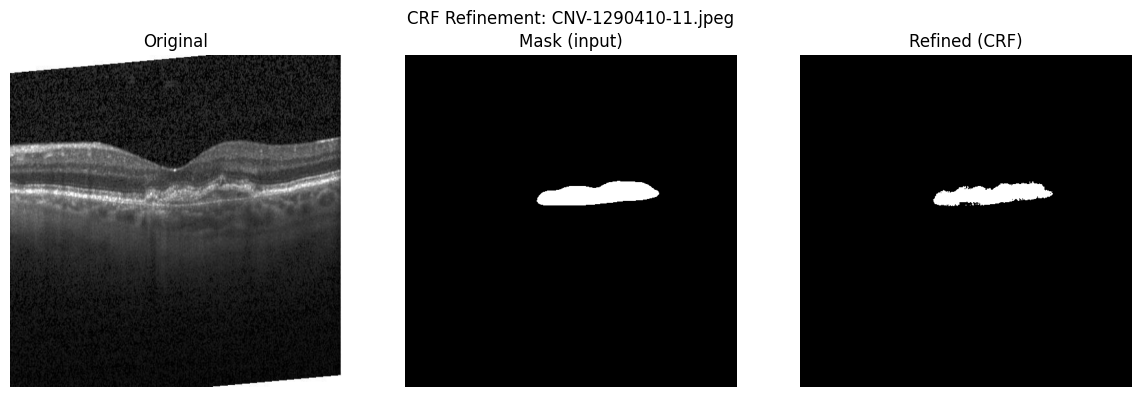

CNV-1290410-21.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


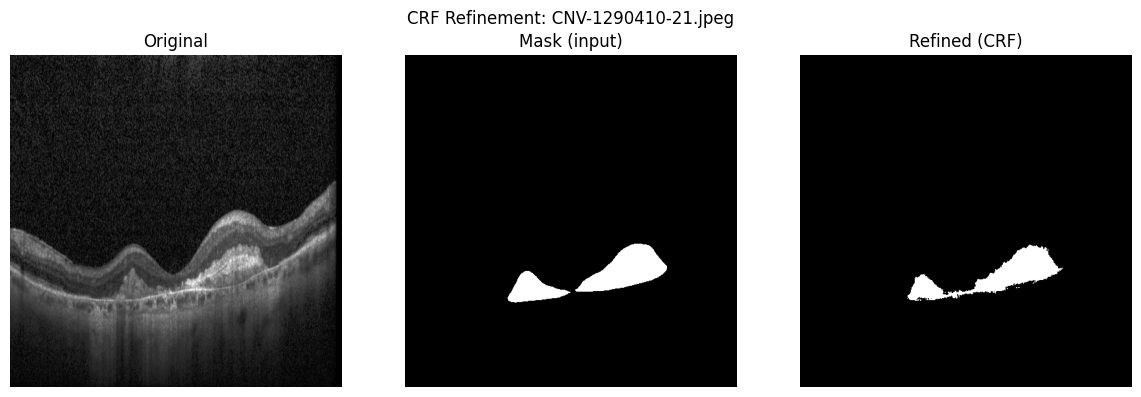

CNV-1305450-109.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


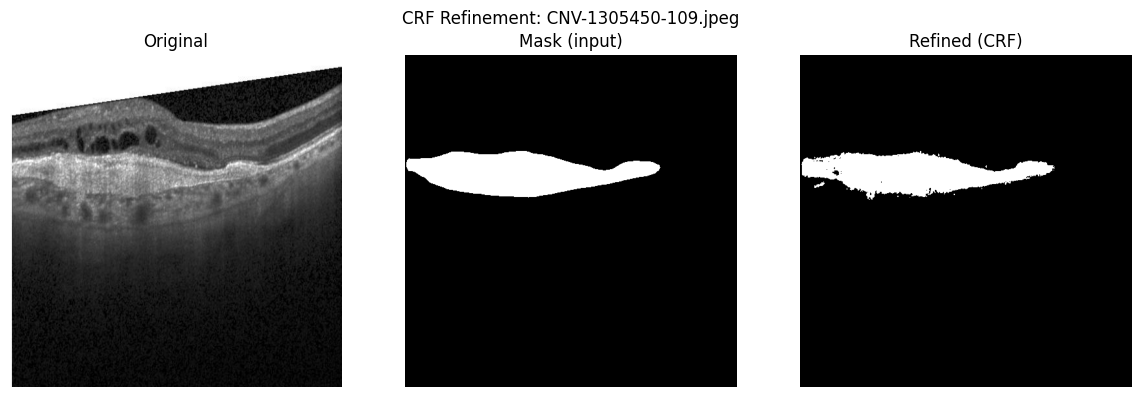

CNV-1305450-12.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


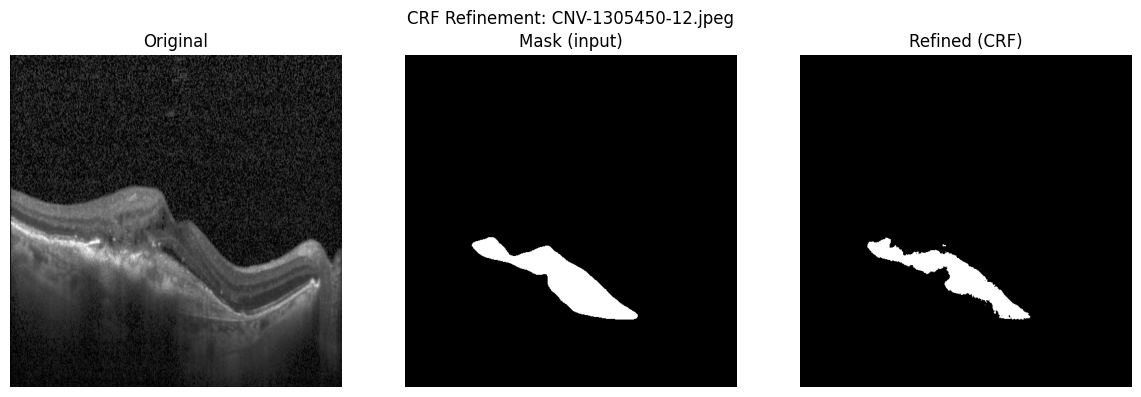

CNV-1305450-15.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,0.9999] mask(512, 512)


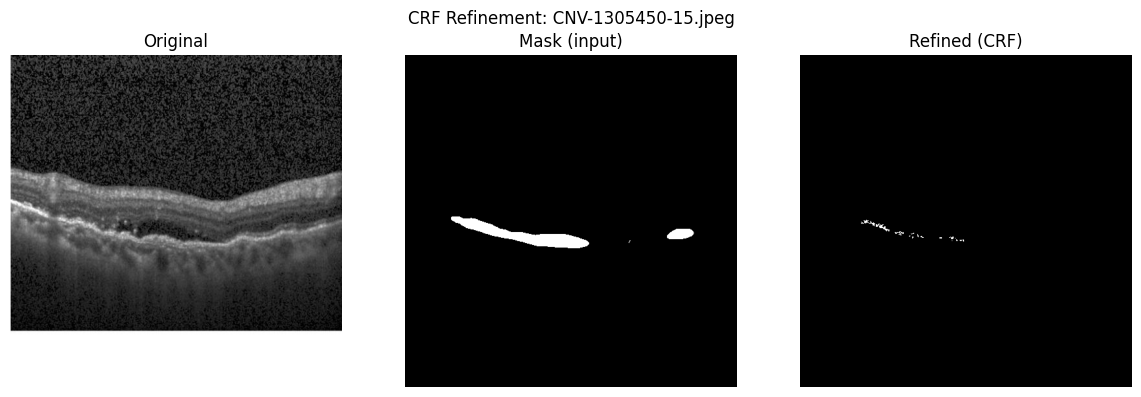

CNV-1305450-153.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


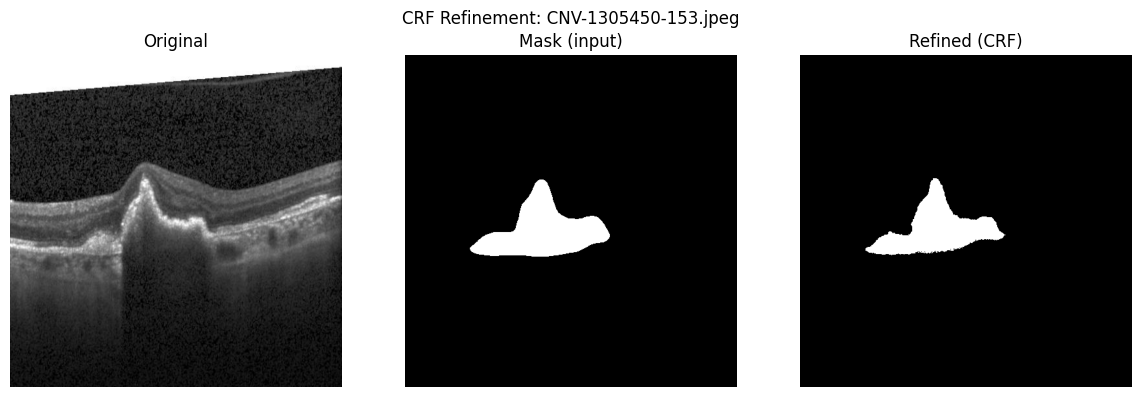

CNV-1322624-161.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


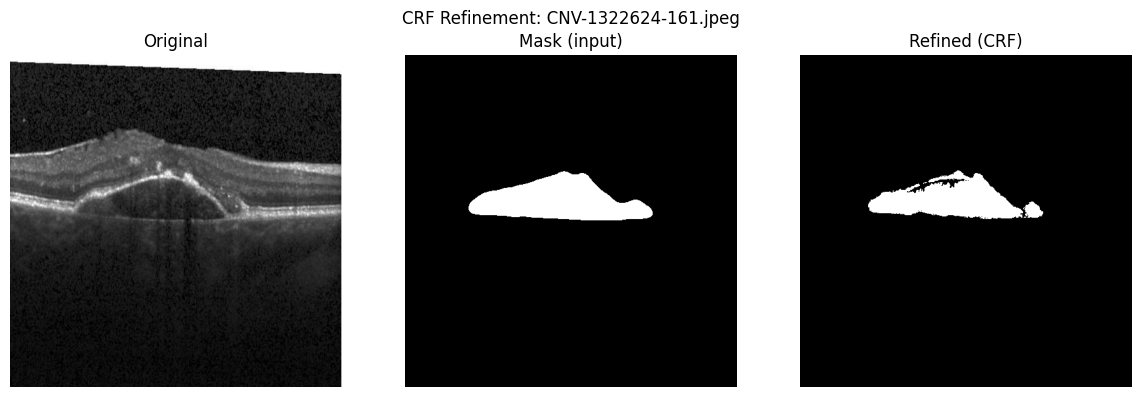

CNV-135126-24.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,0.9491] mask(512, 512)


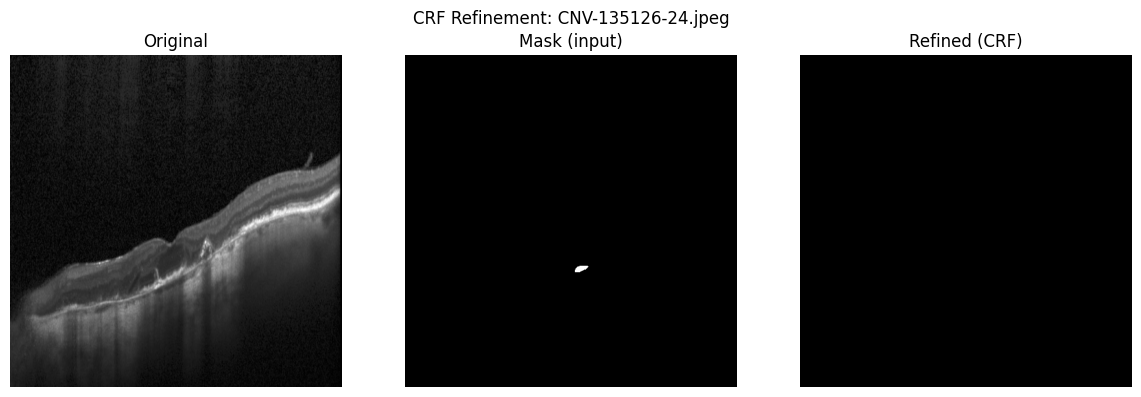

CNV-1356232-17.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


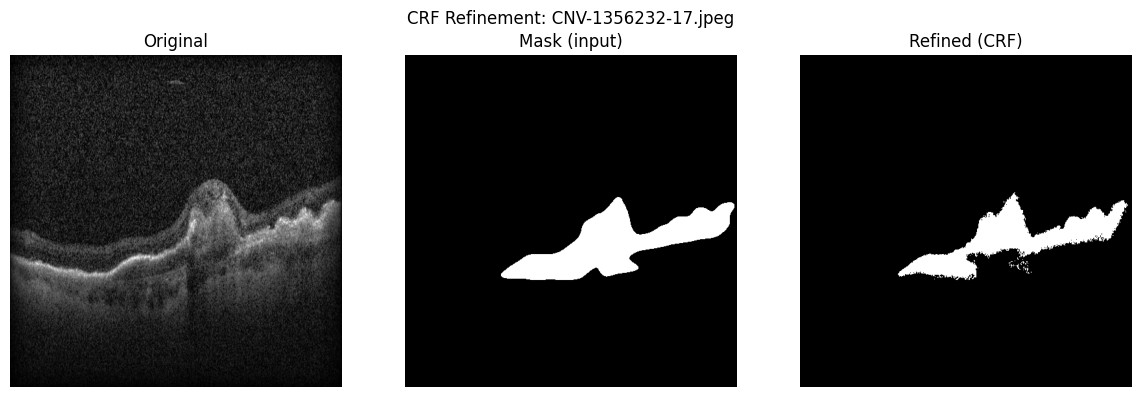

CNV-137351-112.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


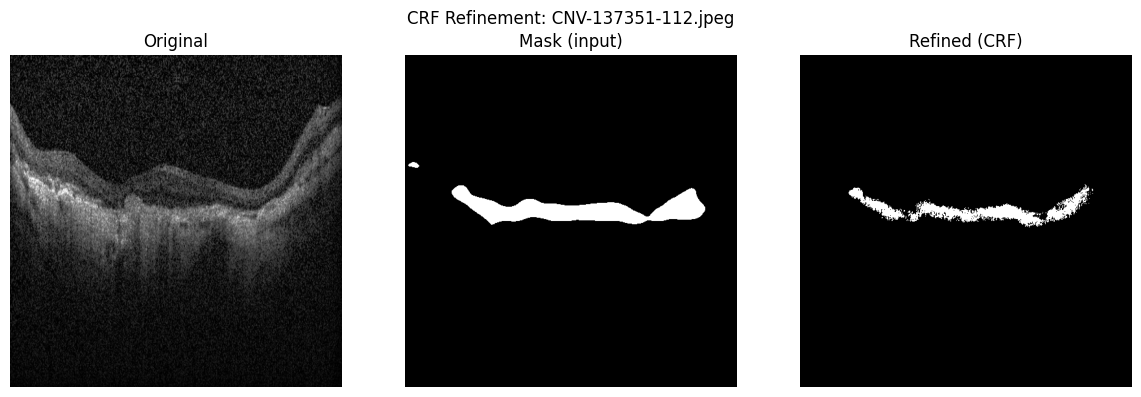

CNV-137351-121.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


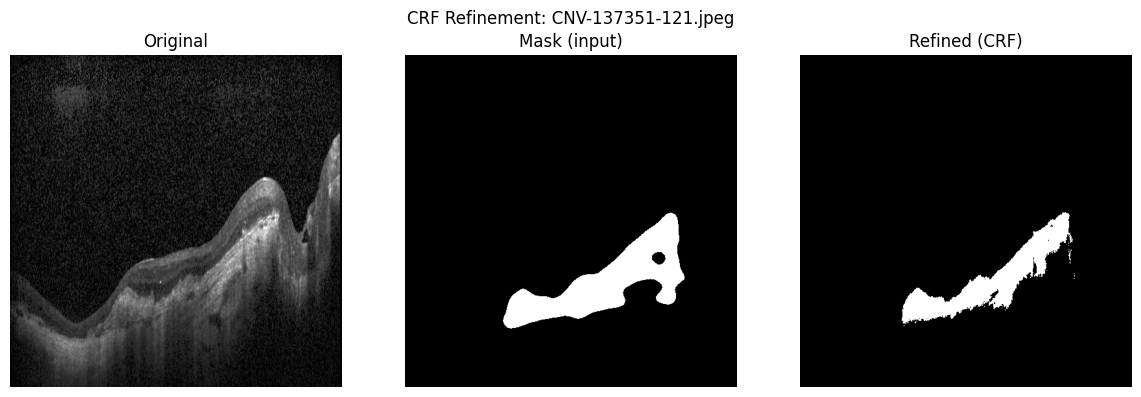

CNV-1390155-37.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


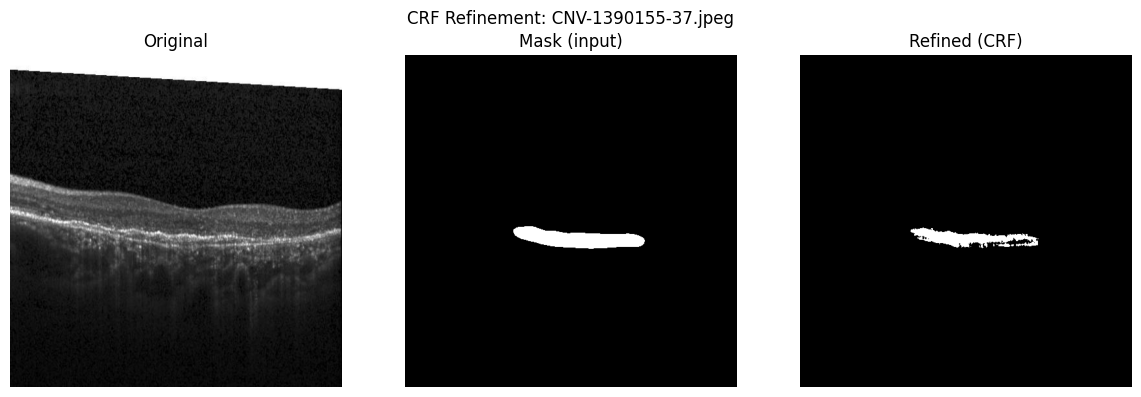

CNV-1390155-83.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


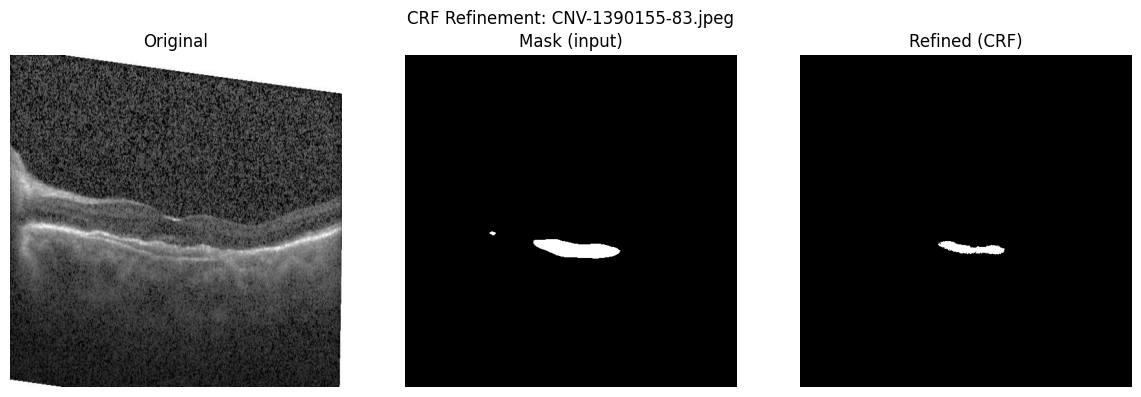

CNV-1390155-84.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


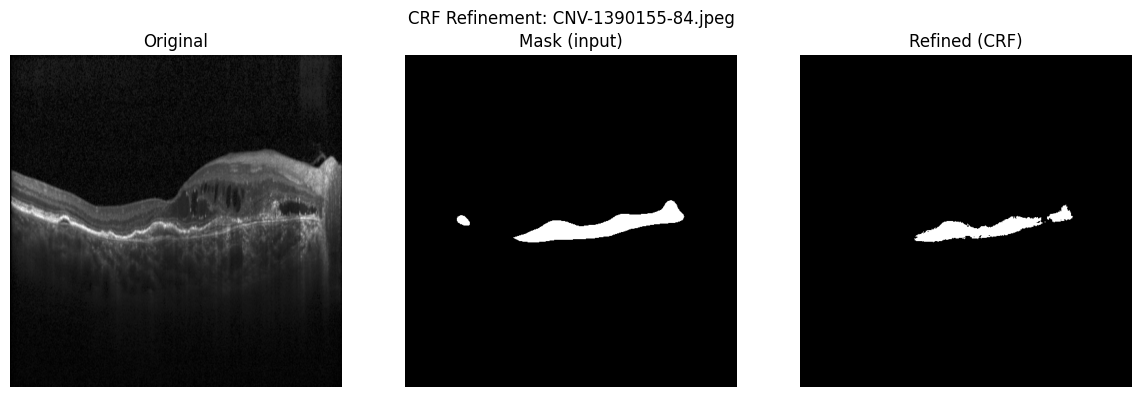

CNV-154835-96.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


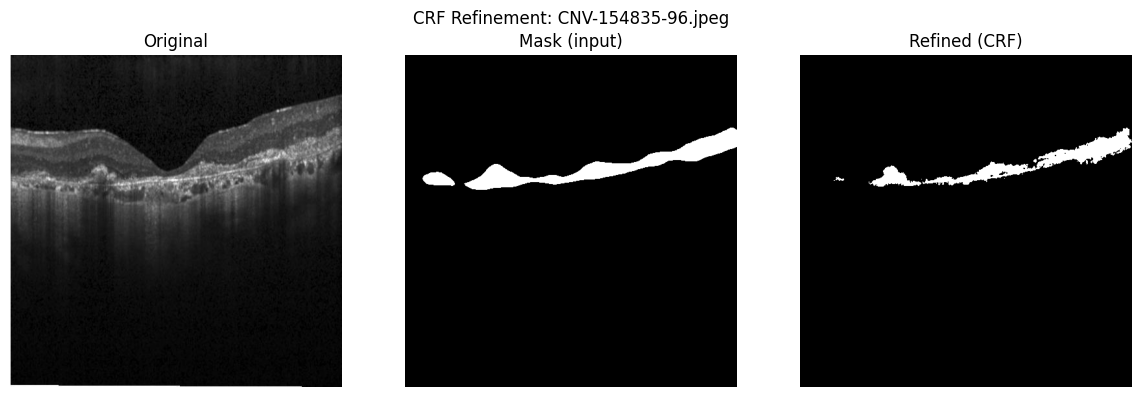

CNV-163081-146.jpeg: img(512, 512, 3) pm(512, 512)[0.0000,1.0000] mask(512, 512)


KeyboardInterrupt: 

In [49]:
crf_eval_folder(
    image_path_folder="/Users/ammaster10/Documents/Github/Year4/CNVresearch/Validation/340_Folder/340_Test",
    mask_path_folder="/Users/ammaster10/Documents/Github/Year4/CNVresearch/Validation/340_Folder/GVF_Ready",
    prob_map_folder="/Users/ammaster10/Documents/Github/Year4/CNVresearch/Validation/340_Folder/predicted_prob_maps_npy",
    cocojson_file="/Users/ammaster10/Documents/Github/Year4/CNVresearch/Validation/340_Folder/subset_340.json",
    limit=None,
    save_refined_to="/Users/ammaster10/Documents/Github/Year4/CNVresearch/Validation/340_Folder/CRF_Refined",
    show=True
)